# Airbus Verde Dataset

## Creating crop attribute time series for a field

This is the code that was used to create the time series of crop attributes available from the Airbus Verde dataset, explained at this LINK. Writing this code was greatly facilitated by using our [GraphQL Explorer](https://app.agrimetrics.co.uk/#/graph-explorer), which provides a graphical way to construct a query and then export the Python code that can be run to execute that query. If you are unfamiliar with GraphQL, you may want to visit the [tutorial](../graphql-examples/using_graphql_intro.ipynb) first.

First, get the modules we need, and an API subscription key. See the note in the [GraphQL tutorial](../graphql-examples/using_graphql_intro.ipynb) about retrieving your API key, and safely using it.

In [29]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np

if "API_KEY" in os.environ:
    API_KEY = os.environ["API_KEY"]
else:
    API_KEY = input("Query API Subscription Key: ").strip()
    
common_headers = {
    "OCP-APIM-Subscription-Key": API_KEY
}

In order to use this notebook, you will need to have registered one crop-specific interest and one non-crop-specific interest for the Verde trial field `agfd:-Dzkwq1lmP0VkSfEcpSqsQ`. If you have run the [walkthrough tutorial](./walkthrough.ipynb), you should already have these interests registered for that field.

In [30]:
# This code was created automatically within GraphQL explorer and copied, pasted here, and executed
# This code executes an API query to the Agrimetrics linked-data service to return field attribute
# data for a specific field from the Airbus Verde dataset.

import requests

url = "https://api.agrimetrics.co.uk/graphql"

payload = {"query":"query getFieldIdAtLocation { fields(where: {id: {EQ: \"agfd:-Dzkwq1lmP0VkSfEcpSqsQ\"}}) { id cropObservations { brownVegetationCoverFraction { mean dateTime validity standardDeviation } canopyFoliageMeanAngle { dateTime mean standardDeviation validity } canopyHoles { dateTime mean standardDeviation validity } canopyShadowFactor { mean standardDeviation dateTime validity } canopyWetnessVerticalBalance { mean dateTime standardDeviation validity } chlorophyllContent { dateTime mean standardDeviation cropType validity } flowerStoreyCoverFraction { dateTime mean standardDeviation validity } fractionOfAbsorbedPhotosyntheticallyActiveRadiation { mean dateTime standardDeviation validity } greenVegetationCoverFraction { mean dateTime standardDeviation validity } leafAreaIndex { dateTime mean standardDeviation cropType validity } leafBrownIndex { dateTime mean standardDeviation validity } leafWaterContent { dateTime mean standardDeviation validity } normalisedDifferenceVegetationIndex { dateTime mean standardDeviation validity } soilFraction { dateTime mean standardDeviation validity } soilWaterSaturationFraction { dateTime mean standardDeviation validity } } } } "}
headers = {
    'Accept': "application/json",
    'Ocp-Apim-Subscription-Key': API_KEY,
    'Content-Type': "application/json",
    'Accept-Encoding': "gzip, deflate, br",
}

response = requests.request("POST", url, json=payload, headers=headers)

response.raise_for_status()
response_json = response.json()

We now have the raw JSON query result from GraphQL. We can now extract the data fields separately from that into a data frame. Finally, set up a list of variable descriptions which we will use later for processing the individual data series.

In [31]:
df_results = pd.DataFrame(response_json['data']['fields'])
df_results2 = df_results['cropObservations'][0]

variablesList = [('brownVegetationCoverFraction', 'Brown Vegetation Cover Fraction', 'fraction'),
                 ('canopyFoliageMeanAngle', 'Canopy Foliage Mean Angle', 'degrees'),
                 ('canopyHoles', 'Canopy Holes', 'unitless'),
                 ('canopyShadowFactor', 'Canopy Shadow Factor', 'unitless'),
                 ('canopyWetnessVerticalBalance', 'Canopy Wetness Vertical Balance', 'unitless'),
                 ('chlorophyllContent', 'Chlorophyll Content', 'micrograms m-2'),
                 ('flowerStoreyCoverFraction', 'Flower Storey Cover Fraction', 'fraction'),
                 ('fractionOfAbsorbedPhotosyntheticallyActiveRadiation', 'Fraction Of Absorbed Photosynthetically Active Radiation', 'fraction'),
                 ('greenVegetationCoverFraction', 'Green Vegetation Cover Fraction', 'fraction'),
                 ('leafAreaIndex', 'Leaf Area Index', 'm2 per m2'),
                 ('leafBrownIndex', 'Leaf Brown Index', 'unitless'),
                 ('leafWaterContent', 'Leaf Water Content', 'g m-2'),
                 ('normalisedDifferenceVegetationIndex', 'Normalised Difference Vegetation Index', 'unitless'),
                 ('soilFraction', 'Soil Fraction', 'fraction'),
                 ('soilWaterSaturationFraction', 'Soil Water Saturation Fraction', 'fraction')]

Now, create a dictionary of dataframes (tables), one for each of the Verde field attributes that we defined above.

In [34]:
dataframe_collection = {} 

for (verdeOutput, *args) in variablesList:
    data = pd.DataFrame(df_results2[verdeOutput])
    data = data[(data.validity > 0.9)]

    # Get LAI for grass only
    if ((verdeOutput == 'leafAreaIndex')):
        data = data[(data.cropType == 'GRASS')]

    # Format the datestamp of the data reading
    data['dateTime'] = pd.to_datetime(data['dateTime'])

    # Don't allow the lower error bar to drop below zero
    data['U95'] = data['mean'] + data['standardDeviation']
    data['L95'] = data['mean'] - data['standardDeviation']
    data.loc[(data['mean'] > 0) & (data['L95'] < 0), 'L95'] = 0

    # Add the data frame to the collection
    dataframe_collection[verdeOutput] = pd.DataFrame(data)

Finally, loop through the field attributes, and for each one create a time series graph. This example creates a version of the graph in the browser for immediate viewing, and also saves a copy of the file in the local directory for use elsewhere.

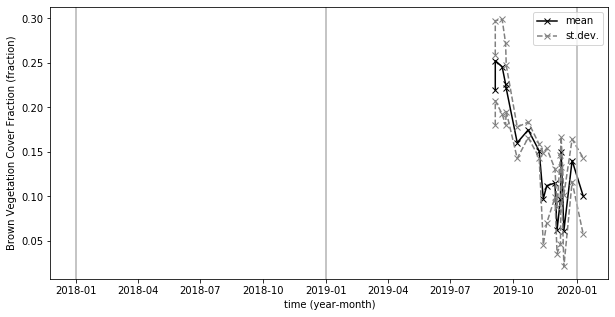

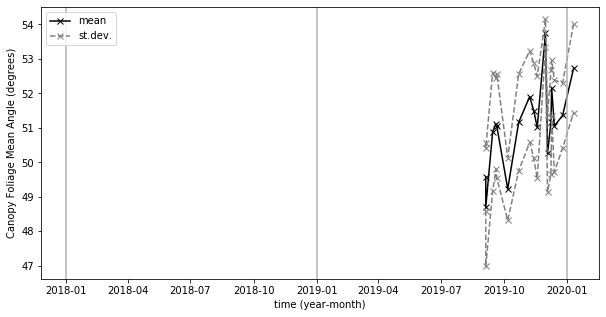

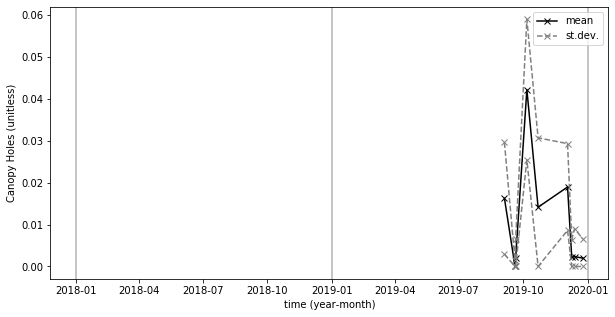

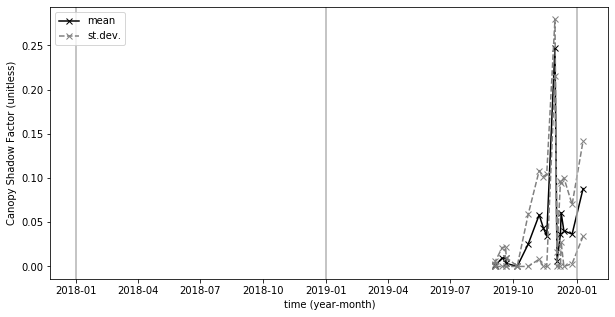

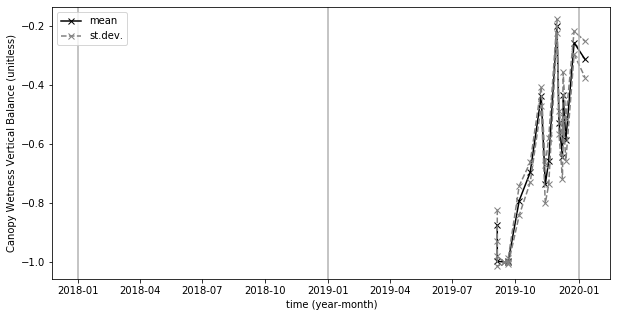

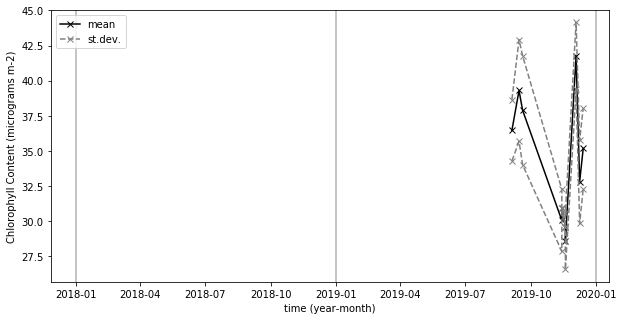

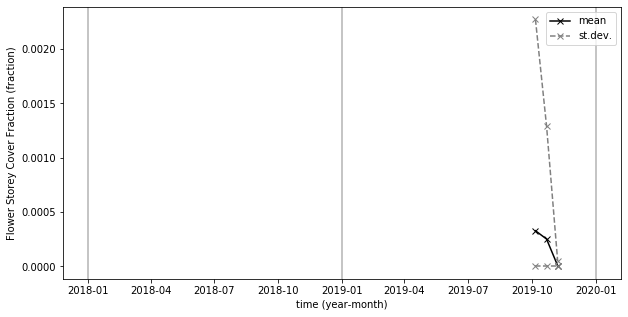

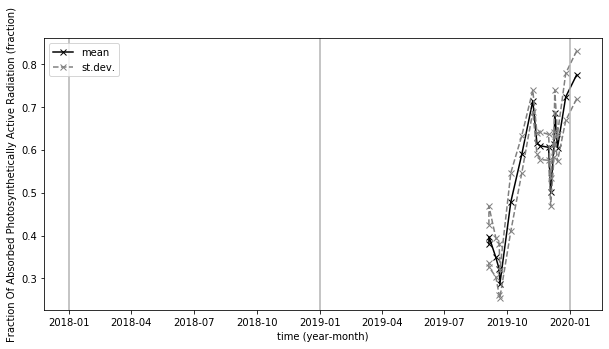

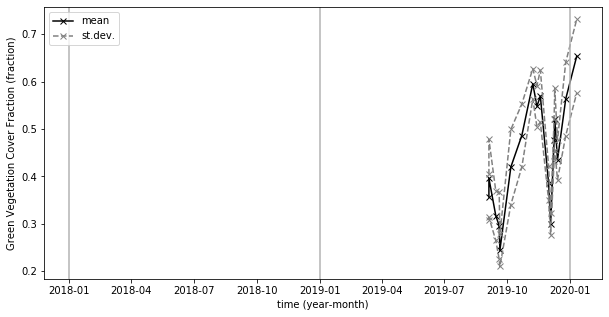

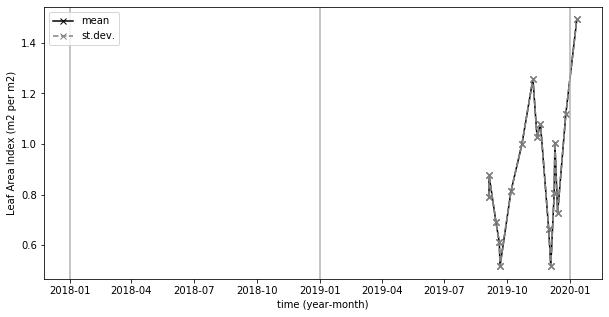

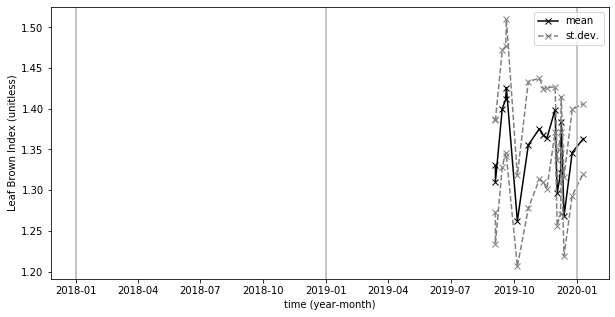

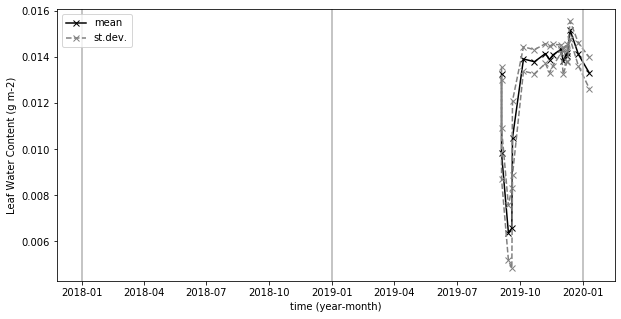

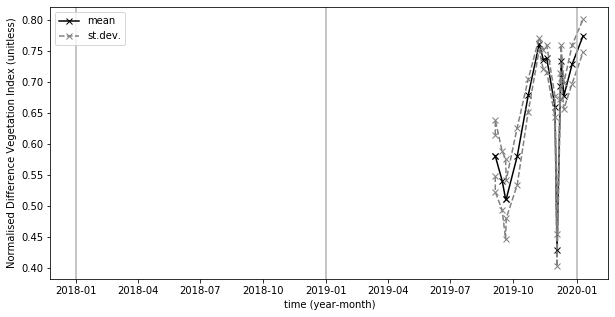

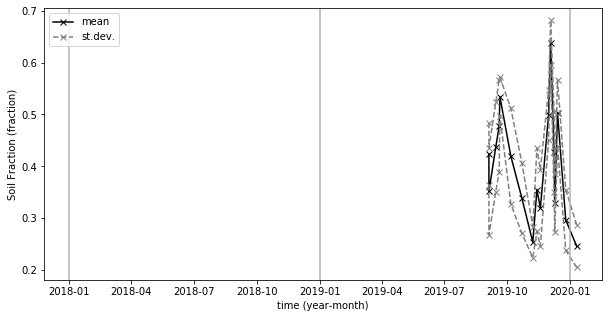

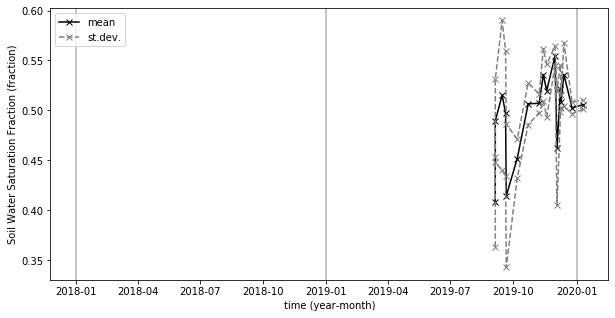

In [35]:
for ind, (verdeOutput, legendName, legendUnit) in enumerate(variablesList):
    plotter = dataframe_collection[verdeOutput]
    fig1 = figure(num=None, figsize=(10, 5))
    
    xlab = 'time (year-month)'
    ylab = f'{legendName} ({legendUnit})'
    
    ax=fig1.add_subplot(111)
    
    ax.plot(plotter['dateTime'], plotter['mean'], '-x', color='black', label='mean')
    ax.plot(plotter['dateTime'], plotter['U95'], '--x', color='gray', label='st.dev.')
    ax.plot(plotter['dateTime'], plotter['L95'], '--x', color='gray')
    
    ax.legend()
    
    maxValue = max(plotter['U95'])
    minValue = min(plotter['L95'])
    
    years = ['2018-01-01 00:00:00+00:00', '2019-01-01 00:00:00+00:00', '2020-01-01 00:00:00+00:00']
    years = np.array(years)
    years = pd.to_datetime(years)
    maxMin = [minValue, maxValue]
    for d in years:
        plt.axvline(d, color=[0.7,0.7,0.7], linestyle='solid')
    
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    
    figlab = f'{verdeOutput}.png'
    fig1.savefig(figlab)
